# Denoising Diffusion Implicit Models (DDIM)
In this notebook, we will be working on implementing [DDIM](https://arxiv.org/abs/2010.02502). To speed up the implementation process, the first 3/4 of the notebook will be heavily following Jeremy Howard's notebook. I will instead spend more time on the last 1/4, which is implementing the paper from scratch myself.

In [118]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [119]:
from fastprogress.fastprogress import progress_bar

In [120]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [121]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

HuggingFace's `diffusers` already implements DDIM. Before we implement it ourselves, let's use HF's code as a baseline.

In [122]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler

In [123]:
class UNet(UNet2DModel): pass

In [124]:
model = torch.load('models/fashion_ddpm3_10.pkl').to(def_device)

In [125]:
sched = DDPMScheduler(beta_end=0.01)

In [126]:
x_t = torch.rand((32, 1, 32, 32)).to(def_device)

In [127]:
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [128]:
noise.shape

torch.Size([32, 1, 32, 32])

In [129]:
res = sched.step(noise, t, x_t) # try to remove noise from x_t

In [130]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [131]:
sz = (128, 1, 32, 32)

In [132]:
%%time
x_t = torch.randn(sz, device=def_device)
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 3min 21s, sys: 23.5 s, total: 3min 44s
Wall time: 10min 54s


In [133]:
len(preds[-1])

128

In [134]:
s = preds[-1].clamp(-0.5, 0.5) * 2

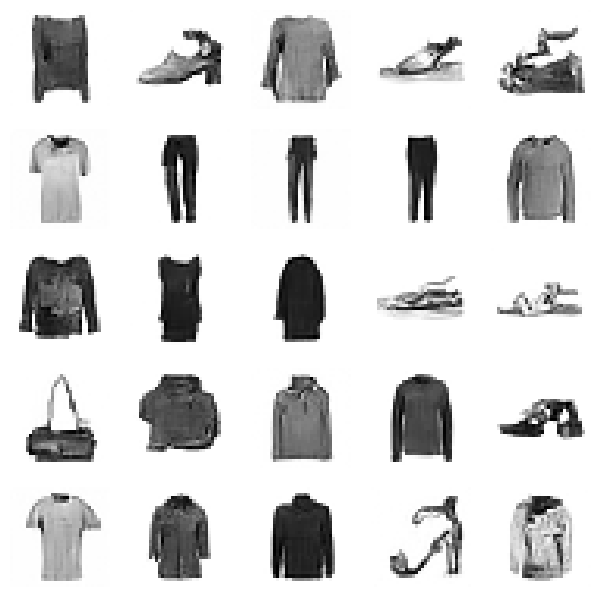

In [135]:
show_images(s[:25], imsize=1.5)

In [136]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [137]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [138]:
ie.fid(s), ie.kid(s)

(45.7457275390625, 0.15750491619110107)

In [139]:
ie.fid(xb), ie.kid(xb)

(0.0540771484375, 0.03090115264058113)

I'm using much smaller batch sizes in generating `s`, which could be the reason why for the much higher FID score (contrast with the much lower KID score).

KID is probably a better score in this context, given my small batch size.

## Diffusers DDIM Scheduler

In [140]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [141]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz, device=def_device)
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [142]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1] * 2).clamp(-1, 1)

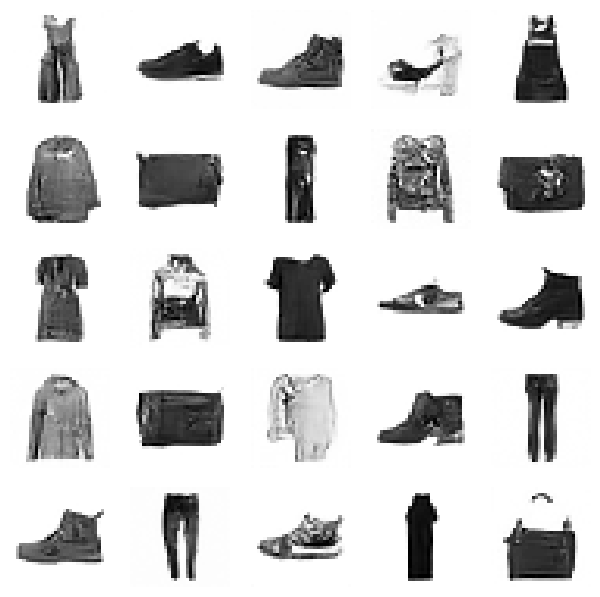

In [143]:
show_images(s[:25], imsize=1.5)

In [144]:
ie.kid(s)

0.08194828033447266

## Implementing DDIM
DDIM has the same training process as DDPM. The key change is in the sampling step, where it allows for deterministic sampling, and also faster sampling via having 'skip steps'.

In [145]:
from types import SimpleNamespace

In [146]:
n_steps = 1000 # no change

In [147]:
def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    beta = torch.linspace(beta_min, beta_max, n_steps)
    return SimpleNamespace(alpha=1.-beta, alpha_bar=(1.-beta).cumprod(0), sigma=beta.sqrt())

In [148]:
sched = linear_sched(beta_max=0.01, n_steps=n_steps)
alpha = sched.alpha
alpha_bar = sched.alpha_bar
sigma = sched.sigma

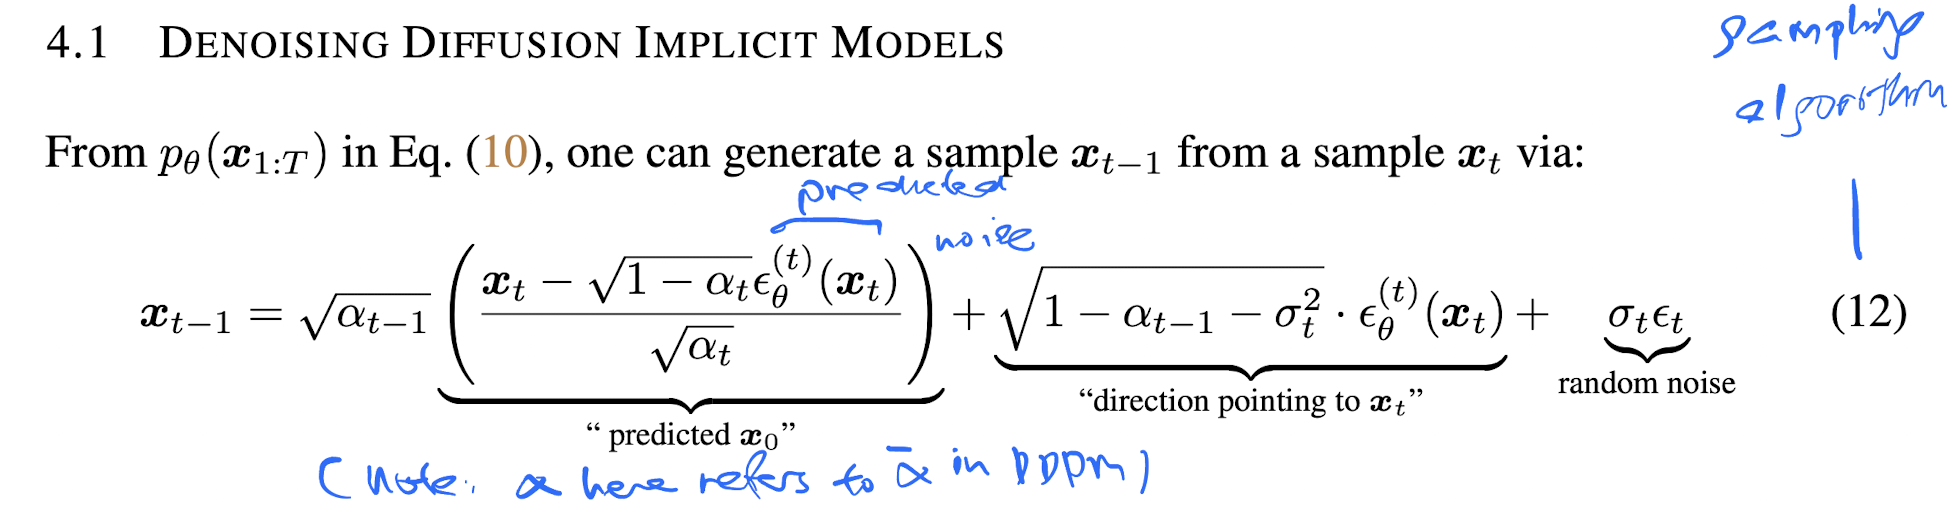

In [149]:
%matplotlib inline
from IPython.display import Image
Image('img/Screenshot 2023-12-22 at 4.34.10 PM.png')

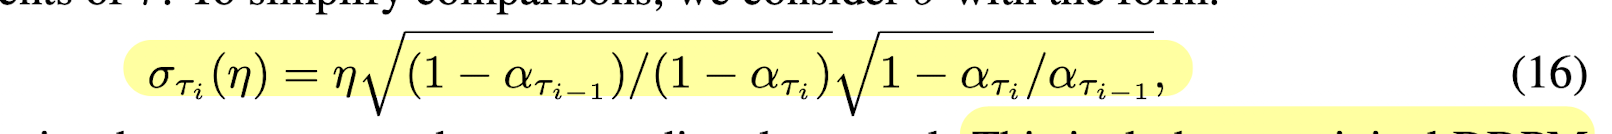

In [150]:
%matplotlib inline
from IPython.display import Image
Image('img/Screenshot 2023-12-22 at 4.55.21 PM.png')

### My code

In [163]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, eta):
    sigma = eta * ((1 - abar_t1)/(1-abar_t)).sqrt() * (1 - abar_t/abar_t1).sqrt()
    x_0_hat = (x_t - (1-abar_t).sqrt() * noise) / abar_t.sqrt()
    dir_to_x_t = (1 - abar_t1 - sigma**2).sqrt() * noise
    random_noise = sigma * torch.randn(x_t.shape, device=x_t.device) if t>0 else torch.zeros(x_t.shape, device=x_t.device)

    x_t = abar_t1.sqrt() * x_0_hat + dir_to_x_t + random_noise
    return x_t

In [164]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    x_t = torch.randn(sz, device=model.device)
    preds = []
    tsteps = list(reversed(range(0, n_steps, skips)))
    for i, t in enumerate(progress_bar(tsteps)):
        with torch.no_grad(): noise = model(x_t, t).sample
        abar_t = alpha_bar[t]
        abar_t1 = alpha_bar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        x_t = f(x_t, t, noise, abar_t, abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

In [165]:
%%time
samples = sample(ddim_step, model, sz, n_steps, skips=10, eta=1.)

CPU times: user 19.7 s, sys: 2.74 s, total: 22.4 s
Wall time: 1min 6s


`samples` refers to the predictions of each batch of images made at each time step. We take the final time step since that is supposed to be the denoised image.

In [166]:
samples

[tensor([[[[ 0.1202,  1.1812,  0.1584,  ...,  1.0750,  1.5847,  0.4921],
           [-1.4259,  0.8219, -0.3263,  ..., -1.1312,  1.9438,  1.5291],
           [-0.2052, -1.2931,  0.7828,  ...,  1.7136,  0.2177,  1.0983],
           ...,
           [-1.1509,  0.2690,  1.7010,  ...,  0.1070,  0.1339, -2.3309],
           [-1.0291, -0.5940,  1.5051,  ..., -1.4638, -0.7614,  2.2397],
           [-1.0195,  0.2238,  0.3028,  ...,  0.1051, -0.1061,  1.4316]]],
 
 
         [[[-0.7936,  0.6160,  0.0056,  ...,  0.2730,  1.5049,  0.9800],
           [ 0.2293, -1.4425, -1.2289,  ...,  0.1284,  0.6255, -0.4151],
           [-0.8425, -0.7486,  0.5070,  ..., -0.7138, -0.4174, -0.8329],
           ...,
           [-2.1509,  0.6285,  1.2342,  ...,  0.3745,  1.2923, -0.4497],
           [ 1.2445,  0.6811, -1.1786,  ..., -0.4667,  0.4688,  0.2594],
           [ 0.7413,  1.0076,  0.0505,  ...,  0.6068, -0.4328,  1.1217]]],
 
 
         [[[-2.0240,  0.1080,  0.7095,  ..., -0.3380, -1.0633,  0.8705],
       

In [167]:
torch.min(samples[-1])

tensor(-0.5605)

In [168]:
torch.max(samples[-1])

tensor(0.6148)

In [169]:
s = (samples[-1] * 2).clamp(-1, 1)

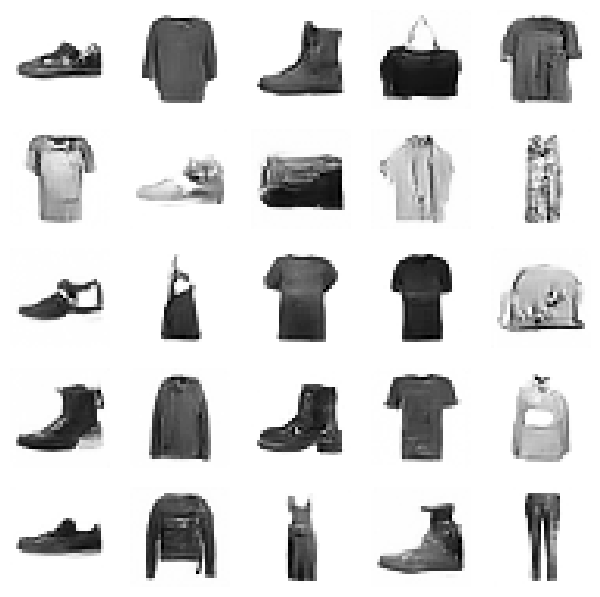

In [170]:
show_images(s[:25], imsize=1.5)

In [171]:
ie.kid(s)

0.15511798858642578